## Mode Summation

Mode summation is the bottleneck of this calculation. We handle this in two ways: interpolation for fast waveforms and direct summation for slow waveforms. They both have the same interface and produce the same product. They take Teukolsky modes and phases and combine that information to create the waveform.  

### Interpolated summation

To maximize efficiency we use the cubic spline discussed above to accelerate the computation with interpolation and parallelized summation (on the GPU or OpenMP). This class is [InterpolatedModeSum](https://bhptoolkit.org/FastEMRIWaveforms/html/user/sum.html#few.summation.interpolatedmodesum.InterpolatedModeSum). 

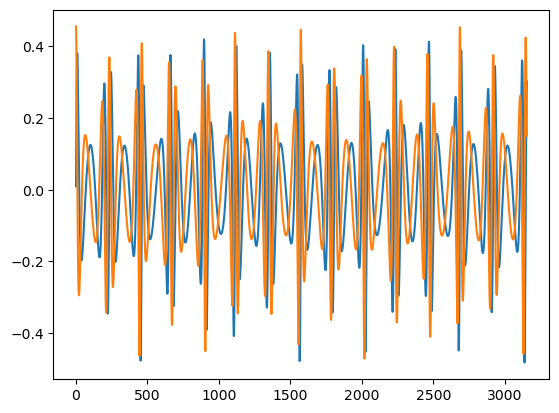

In [37]:
M = 1e6
mu = 1e1
p0 = 12.0
e0 = 0.4
theta = np.pi/5.
phi = np.pi/3.
T = 0.001
dt = 10.0
Tsec = T * YRSID_SI

traj = EMRIInspiral(func=SchwarzEccFlux)
amp = RomanAmplitude()
interpolate_mode_sum = InterpolatedModeSum()
ylm_gen = GetYlms(assume_positive_m=False)

# very simplified waveform example

# Schwarzschild
a = 0.0
xI0 = 1.0

# get trajectory
(t, p, e, x, Phi_phi, Phi_theta, Phi_r) = traj(M, mu, a, p0, e0, xI0, T=T, dt=dt)

ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[
    amp.inverse_lm
]

# amplitudes
teuk_modes = amp(a, p, e, x, amp.l_arr, amp.m_arr, amp.n_arr)

# need to prepare arrays for sum with all modes due to +/- m setup
ls = amp.l_arr[: teuk_modes.shape[1]]
ms = amp.m_arr[: teuk_modes.shape[1]]
ns = amp.n_arr[: teuk_modes.shape[1]]

keep_modes = np.arange(teuk_modes.shape[1])
temp2 = keep_modes * (keep_modes < amp.num_m0) + (
    keep_modes + amp.num_m_1_up
) * (keep_modes >= amp.num_m0)

ylmkeep = np.concatenate([keep_modes, temp2])
ylms_in = ylms[ylmkeep]
teuk_modes_in = teuk_modes

# summation
waveform1 = interpolate_mode_sum(t, teuk_modes_in, ylms_in, traj.integrator_spline_t, traj.integrator_spline_phase_coeff[:,[0,2]], amp.m_arr, amp.n_arr, dt=dt, T=T)

plt.plot(waveform1.real)
plt.plot(waveform1.imag)

### Direct summation

For the direct mode summation, [DirectModeSum](https://mikekatz04.github.io/FastEMRIWaveforms/html/user/sum.html?highlight=interpolated%20mode%20sum#few.summation.directmodesum.DirectModeSum), we are summing up all modes at each time step directly. So, no interpolation. However, in this example, we will use interpolation up front because we need  amplitude and phase arrays at all time steps for the direct mode sum because the direct mode sum will not fill in time steps like the interpolated mode sum.  

Mismatch: 1.1102230246251565e-16


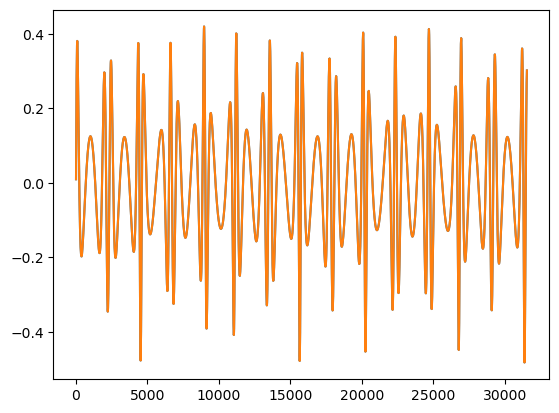

In [38]:
interp_in = np.zeros((teuk_modes.shape[1] * 2, teuk_modes.shape[0]))
                     
interp_in[:teuk_modes.shape[1], :] = teuk_modes.T.real
interp_in[teuk_modes.shape[1]:, :] = teuk_modes.T.imag

spline = CubicSplineInterpolant(t, interp_in)

# get new values
t_new = np.arange(t[0], t[-1], dt)

interp_in2 = np.zeros((3, teuk_modes.shape[0]))
interp_in2[0] = Phi_phi
interp_in2[1] = Phi_theta
interp_in2[2] = Phi_r

spline2 = CubicSplineInterpolant(t, interp_in2)

Phi_phi_in, Phi_theta_in, Phi_r_in = spline2(t_new)

# notice the new shape is (ninterps, length) just like the inital input to the spline
temp = spline(t_new).T


teuk_modes_in = temp[:, :teuk_modes.shape[1]] + temp[:, teuk_modes.shape[1]:]*1j

direct_mode_sum = DirectModeSum()

waveform2 = direct_mode_sum(t, teuk_modes_in, ylms_in, t, [Phi_phi_in, Phi_theta_in, Phi_r_in ], amp.m_arr[:teuk_modes.shape[1]], amp.n_arr[:teuk_modes.shape[1]], dt=dt, T=T)
plt.plot(t_new, waveform1.real)
plt.plot(t_new, waveform2.real)

print('Mismatch:', get_mismatch(waveform1, waveform2))